In [1]:
import os
from pathlib import Path
import numpy as np

import pandas as pd

from sbdata.FlipsideApi import FlipsideApi

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'passport')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')

# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)


PATH_TO_LOKI = os.path.join(DATA_DIR, "thor_loki.csv")
PATH_TO_SYBILS_GR15 = os.path.join(DATA_DIR, "alpha_round_sybils.xlsx")


df_loki = pd.read_csv(PATH_TO_LOKI)
df_sybils_gr15_oss = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=3)
df_sybils_gr15_eth = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=4)
df_sybils_gr15_climate = pd.read_excel(PATH_TO_SYBILS_GR15, sheet_name=5)

In [2]:
df_loki.dropna(subset=['Wallet Address', 'Thor/Loki Indicator'], inplace=True)
df_loki.drop_duplicates(subset=['Wallet Address'], inplace=True)

In [3]:
print(df_sybils_gr15_oss.iloc[0, 0])
print(df_sybils_gr15_eth.iloc[0, 0])
print(df_sybils_gr15_climate.iloc[0, 0])

GBfhgm6rM89PeSDsoT9kPmSXsbWhezXYk6EhYUFrcJ6
A6dP7TpAjZ5zDTLVLin62EJcWZzUTaEh1WYbeFGcfXNc
HGAJ8yQiSwRFGQJUR6CruhHuPTpXz5Dvt1XVn3YGpQKA


In [4]:
df_sybils_gr15_oss.dropna(subset=['ID'], inplace=True)
df_sybils_gr15_eth.dropna(subset=['ID'], inplace=True)
df_sybils_gr15_climate.dropna(subset=['ID'], inplace=True)

In [5]:
addresses = df_loki['Wallet Address'].tolist()
addresses += df_sybils_gr15_oss['Source Address'].tolist()
addresses += df_sybils_gr15_eth['Source Address'].tolist()
addresses += df_sybils_gr15_climate['Source Address'].tolist()
print(f'addresses {len(addresses)}')
unique_addresses = np.unique(np.array(addresses))
print(f'unique_addresses {len(unique_addresses)}')
print(f'{len(addresses) - len(unique_addresses)} duplicates')

addresses 14598
unique_addresses 6217
8381 duplicates


In [6]:
other_add = df_sybils_gr15_oss['Source Address'].tolist()
other_add += df_sybils_gr15_eth['Source Address'].tolist()
other_add += df_sybils_gr15_climate['Source Address'].tolist()
other_unique_address = np.unique(np.array(other_add))
print(f'addresses {len(other_add)}')
print(f'unique_addresses {len(other_unique_address)}')
print(f'{len(other_add) - len(other_unique_address)} duplicates')

addresses 10167
unique_addresses 1855
8312 duplicates


In [7]:
print(df_loki.shape)
print(df_sybils_gr15_oss.shape)
print(df_sybils_gr15_eth.shape)
print(df_sybils_gr15_climate.shape)

(4431, 9)
(8139, 15)
(1355, 10)
(673, 10)


There is a lot of addresses to query lets see how we can reduce that number

In [8]:
df_loki['Thor/Loki Indicator'].value_counts()

Thor/Loki Indicator
thor    2383
loki    2048
Name: count, dtype: int64

Thor Loki data set is relatively well balanced so we will start with that

In [9]:
df_loki['Wallet Address'] = df_loki['Wallet Address'].str.lower()

In [10]:
loki_unique_address = df_loki['Wallet Address'].unique()

In [11]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)

In [12]:
df_tx = data_loader.create_df_tx('ethereum', loki_unique_address.tolist())

In [13]:
print(df_tx.EOA.nunique())
print(len(loki_unique_address))

4187
4431


In [14]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [15]:
df_label.head(2)

,address,creator,label_type,address_name,project_name,__row_index
0,0xf845cba831be88268b1415d976db0afc7b8c6357,flipside,dex,uniswap v3 dsla/wrapped ether 0.3%,uniswap,0
1,0xf86c94c39a11e9535cabdf3ca07149eb0e7f24cc,flipside,dex,direwolf/weth pool,shibaswap,1


In [16]:
array_pool_address = df_label['address'].unique()

In [17]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(loki_unique_address))

In [18]:
tx_analyser.set_group_by_sorted_EOA()


In [49]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [20]:
df_loki.reset_index(inplace=True, drop=True)

Some of the addresses are not in the data set so we will need to filter them out

In [34]:
loki_unique_address = np.intersect1d(loki_unique_address, df_loki['Wallet Address'].unique())

In [42]:
loki_unique_address = np.intersect1d(loki_unique_address, df_tx.EOA.unique())

In [44]:
df_loki = df_loki[df_loki['Wallet Address'].isin(loki_unique_address)]

In [46]:
assert df_loki.shape[0] == len(loki_unique_address)
print(df_loki.shape)

(4187, 9)


In [50]:
df_loki['count_interaction_with_any'] = df_loki['Wallet Address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [51]:
(df_loki['count_interaction_with_any'] > 0).sum()

1906

<Axes: xlabel='Thor/Loki Indicator', ylabel='count_interaction_with_any'>

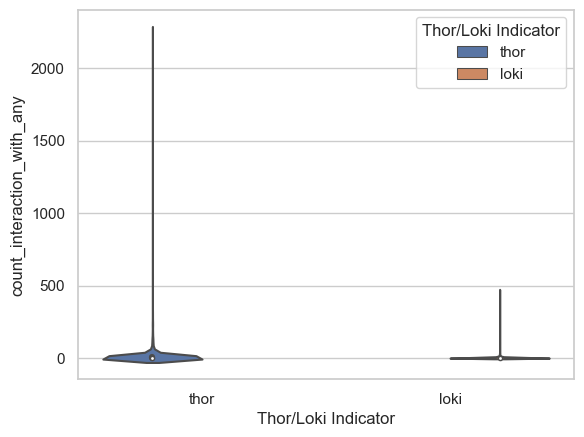

In [54]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.violinplot(df_loki, x="Thor/Loki Indicator", y="count_interaction_with_any", hue="Thor/Loki Indicator")

In [55]:
df_loki['count_interaction_with_any'].describe()

count    4187.000000
mean        7.991641
std        55.132921
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max      2256.000000
Name: count_interaction_with_any, dtype: float64

In [58]:
df_loki.sort_values('count_interaction_with_any', ascending=False).head(10)

,Wallet Address,Gitcoin Handle,Thor/Loki Indicator,Stamps Collected,Logistic Regression Score,Regularized Regression Score,COF Kish Score,Gitcoin Regen Score,Stamps,count_interaction_with_any
2983,0x64abc5b10c77d93be5038e7b4965d2f0d8279127,hypergamedoteth,thor,21,0.999852,0.985764,3476.000,52,"[""GitcoinContributorStatistics#totalContributi...",2256
2964,0x99ed04c212dd3929e9063bd78b26ef41858cb62c,jacobmort,thor,8,0.983923,0.904224,558.500,0,"[""Facebook"", ""Twitter"", ""StarredGithubRepoProv...",1602
2557,0x478fa4c971a077038b4fc5c172c3af5552224ccc,cryptikal514,thor,11,0.739387,0.821560,691.750,0,"[""ZkSync"", ""SnapshotVotesProvider"", ""FirstEthT...",1076
27,0x5d47e5d242a8f66a6286b0a2353868875f5d6068,jokazza84,thor,13,1.000000,0.919659,11543.875,21,"[""ethPossessionsGte#1"", ""ZkSync"", ""FirstEthTxn...",748
2771,0x94692b042a0e36671952ff0b71e43d6e0d06845a,corepl,thor,10,0.651339,0.629363,1312.125,32,"[""ethPossessionsGte#1"", ""ZkSync"", ""GitcoinCont...",674
2589,0x1c494f1919c1512ebe74a5dcc17dac9a64069023,alexisleger-42,thor,20,0.998073,0.990677,2169.750,18,"[""GitcoinContributorStatistics#totalContributi...",572
81,0x2880a6bb2cd1df6e03dc8bbfbed009de586c2603,n1024829,thor,4,0.612315,0.594022,189.500,0,"[""Twitter"", ""POAP"", ""Google"", ""Ens""]",544
2224,0x5db63f987817910bbb9656b5210990408d3831fb,qlonline,loki,22,0.764276,0.841920,2440.875,39,"[""GitcoinContributorStatistics#totalContributi...",468
3340,0x787b4b7ffef8eddad54f311039acf4c36fec9593,roelie885,thor,5,0.742918,0.743101,214.250,0,"[""ZkSync"", ""Ens"", ""POAP"", ""Twitter"", ""TwitterF...",444
2244,0xabca2289f0d03773e8b102248997e854aa36cd21,lostmind84,thor,23,0.999877,0.995306,4558.375,54,"[""GitcoinContributorStatistics#totalContributi...",378


In [69]:
df_loki[np.logical_and(df_loki['count_interaction_with_any'] < 10, df_loki['Thor/Loki Indicator'] == 'loki')].shape

(1758, 10)

In [79]:
df_loki[df_loki['Thor/Loki Indicator'] == 'loki']['count_interaction_with_any'].describe([0.5, 0.75, 0.9, 0.95, 0.99])

count    1823.000000
mean        1.924849
std        12.202839
min         0.000000
50%         0.000000
75%         2.000000
90%         4.000000
95%         8.000000
99%        20.000000
max       468.000000
Name: count_interaction_with_any, dtype: float64

In [80]:
df_loki[df_loki['Thor/Loki Indicator'] == 'thor']['count_interaction_with_any'].describe([0.5, 0.75, 0.9, 0.95, 0.99])

count    2364.000000
mean       12.670051
std        72.246395
min         0.000000
50%         2.000000
75%         6.000000
90%        22.000000
95%        46.000000
99%       185.180000
max      2256.000000
Name: count_interaction_with_any, dtype: float64

From these two percentiles we can understand that a treshold of the number of interactions with a dex should be arround 5

Then a second threshold above 20 would eliminate 99% the addresses that have the loki flag and 90% of the addresses that have the thor flag